In [1]:
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '2'

In [79]:
exec(open('AMES_aux.py').read()) #load functions

### load data

In [3]:
#parameters for data generation
pad_len = 1200 #maximal length of data
asym = ['Li', 'Na', 'K', 'Be', 'Mg', 'Ca', 'Sc', 'Cr', 'Fe', 'Pt', 'Cu', 'Hg', 'B', 'Al', 'C0', 'C1', 'C2', 'C3', 
        'Si', 'Sn', 'N0', 'N1', 'N2', 'P0', 'As', 'Sb', 'O0', 'O1', 'S0', 'S1', 'Se', 'F', 'Cl', 'Br', 'I']
arom = ['c', 'n', 'o', 's']
other = ['X']
one_hot = asym + arom + other

In [4]:
#model parameters
nr_atoms = int(pad_len/8)
input_shape = (150,len(one_hot)+4)
output_shape = 1
filters = [1024, 1024, 1024]
dense_layers = [512]
n = 100
batch_size = 64
opt = optimizers.Adam(lr=0.001)

### load precalculated data or ... 

In [5]:
data = pickle.load(open('/publicdata/graphconv/publication/data/ames_pad1200_2410.p','rb'))
xTest, pTest, yTest, test_mols, xVal, pVal, yVal, val_mols, xTrain, pTrain, yTrain, tr_mols = data.values()
pTest = pTest.toarray().reshape(-1,pad_len,int(pad_len/8+1))
pVal = pVal.toarray().reshape(-1,pad_len,int(pad_len/8+1))
pTrain = pTrain.toarray().reshape(-1,pad_len,int(pad_len/8+1))

### ... generate data from molecules (not needed)

In [5]:
#data generation from scratch
xVal, pVal = Generator(val_mols, one_hot, pad_len)
xTest, pTest = Generator(test_mols, one_hot, pad_len)
xTrain, pTrain = Generator(tr_mols, one_hot, pad_len)

### load model...

In [6]:
model_file = 'ames.h5'

In [7]:
model = load_model(model_file)

### ... or train from scratch (not needed)

In [8]:
model = create_model(input_shape, output_shape, filters, dense_layers, opt)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 44)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1200, 151)    0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 151, 44)      0           input_1[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1200, 44)     0           input_2[0][0]                    
                                                                 zero_padding1d_1[0][0]           
__________

In [10]:
model, tr, val, tst = run_model(model, [xTrain,pTrain], yTrain, [xVal, pVal], yVal, [xTest, pTest], yTest, 
                                n=n, batch_size=batch_size, model_file='ames_from_scratch')

### evaluate model

In [8]:
pval = model.predict([xVal, pVal])
ptst = model.predict([xTest, pTest])

In [9]:
roc_auc_score(yVal, pval), roc_auc_score(yTest, ptst)

(0.9188677817301143, 0.8006412380518888)

### interpret model

In [147]:
x = xVal
p = pVal
y = yVal
mols = val_mols

In [148]:
#layers are a list of indices of the atom representation layers
#returns an array of atom representations and molecule representations
atom_act, mol_act = get_activations(model, x, p, layers=[5,9,13,15], filters=filters, bs=8, pad_len=pad_len) 

In [149]:
#returns unqiue atom representations, the indices of the molecules from which the atoms originate and the atom indicies
#in these molecules
unique, idx, a_idx = reduce_act(atom_act, mols, nr_atoms=nr_atoms) 

In [150]:
#function for atom/substructure scores
atom_scoring = K.function([model.layers[16].input],[model.layers[-1].output]) #adjust layers index to your architecture

In [151]:
#returns the scores for each atom/substructure 3rd layer representation 
a_scores = atom_scoring([unique[:,-filters[-1]:]/nr_atoms, False])[0][:,0] 

In [152]:
atoms_sorted = np.argsort(a_scores)[::-1][:50] #take 50 most important substructures

In [153]:
substr = [get_substruct(np.array(mols)[idx][e],int(a_idx[e]),3) for e in atoms_sorted] #we used the 3 convolutional layers

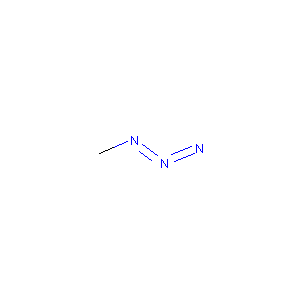

In [161]:
Draw.MolToImage(Chem.MolFromSmarts(Chem.MolToSmarts(substr[0])))